# 1. Data Acquisition & Data Preparation

## Environment Setup

## TPU backend

In [1]:
# # Enabling and testing the TPU
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
# libraries import
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV # I/O separator
from sklearn.preprocessing import StandardScaler # data preparation
from sklearn.preprocessing import MinMaxScaler # !!! recently not used
from tensorflow.keras.utils import to_categorical

# %matplotlib inline # enable visualization visible
random_seed = 20 # random seed

print('\n')
print('necessary libraries has successfully imported')
print('\n')



necessary libraries has successfully imported




In [3]:
# connect to google drive to obtain dataset
# !note: need to perform authorization by following below link
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Acquisition

In [4]:
print('found sample data in specified directory as')
print('\n')

# list all data sample in specific directory
!ls /content/drive/My\ Drive/all_about_phd/phd_data/sample_data

found sample data in specified directory as


ls: cannot access '/content/drive/My Drive/all_about_phd/phd_data/sample_data': No such file or directory


In [5]:
# define path to files
defaultdir = '/content/drive/My Drive/all_about_phd_research/'

## full dataset
# rootdir = defaultdir + 'data_20210218'

## test dataset
rootdir = defaultdir + 'phd_data/sample_data'

## check
print('root directory specify at' , rootdir)
print('\n')

root directory specify at /content/drive/My Drive/all_about_phd_research/phd_data/sample_data




In [6]:
# define dataset & metadata as label function
def read_data_from_files(path=rootdir):
  ## assign dataset & metadata
  X_raw = []
  y_slug= []

  ## iterate through directory
  for subdir, dirs, files in os.walk(rootdir):
      for file in files:
        # filter only for raw file
        if file.endswith('.raw'):
            # assign data -> dataset 
            ## by fixing dimension as follows HSI e.g. 
            ### X = length (collection time dependent),
            ### Y = spectral domain (fixed at 224, all spectra),
            ### Z = width (fixed at 640)
            ### then swap axes between width (Z) vs. spectral (Y)
            X_raw.append(np.fromfile(os.path.join(subdir, file), dtype='uint16').reshape(-1,224,640).swapaxes(1,2))
            
            # assign label -> cut some unneceasary
            y_slug.append(re.search('(\d+.+\d+)', file).group(0))

  # extract label; y <- data_slug using RegEx
  y = np.stack([(int(re.findall('([\d{1}])(?=_)', y_slug[index], flags=0)[0])) for index, _ in enumerate(y_slug)])

  # different class number from label 
  y = to_categorical(y - 1, num_classes=len(list(set(y))))

  del y_slug

  # output type = list (x), array (y)
  return X_raw, y

In [7]:
# aquire dataset using defined function
# !note: this process take some minutes
X_raw, y = read_data_from_files()

print('raw data has acquired as input (X) and output (y)')
print('\n')

raw data has acquired as input (X) and output (y)




Plot example of raw input data
sample index = 2
spectral index = [0, 50, 100, 223]




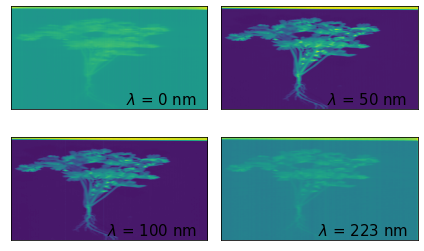

In [8]:
print('Plot example of raw input data')

# show images of sample in a spectrum
figurename = 'Example of images in different spectrals from a single raw coriander sample data'
sample_index = 2

# set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

fig, axes = plt.subplots(nrows=2, ncols=2)

## sample 0th - 3th are selected
## Z; spectral, is randomly specified
axes[0, 0].imshow(X_raw[sample_index][:,:,0])
axes[0, 1].imshow(X_raw[sample_index][:,:,50])
axes[1, 0].imshow(X_raw[sample_index][:,:,100])
axes[1, 1].imshow(X_raw[sample_index][:,:,223])

# decorate
axes[0, 0].set_title((r'$\lambda$ = 0 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[0, 1].set_title((r'$\lambda$ = 50 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[1, 0].set_title((r'$\lambda$ = 100 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[1, 1].set_title((r'$\lambda$ = 223 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
# fig.suptitle(figurename, fontsize=MEDIUM_SIZE) # will be removed
fig.tight_layout()

# save figure
plt.savefig(defaultdir + '/processed_data/' + figurename + '.png')

# declare sample index
print('sample index =', sample_index)
print('spectral index =', [0, 50, 100, 223])
print('\n')

In [9]:
# # disconnect google drive after finish

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

## Data Prepatation

In [10]:
# define shorten all sample length into the shortest length function
def shorten_data(X_raw=X_raw):
  # find minimum raw data length
  length_min = np.amin([X_raw[index].shape[0] for index, _ in enumerate(X_raw)])

  # find minimum raw data length index
  length_min_index = [index for index, _ in enumerate(X_raw) if X_raw[index].shape[0] == length_min][0]

  # filter raw data length to equal to minimum sample length
  X_shorten = np.stack([X_raw[index][:length_min] for index, _ in enumerate(X_raw)], axis=0)

  # output type = array
  return X_shorten

In [11]:
print('performing shorten length of data sample')

# perform shortening function
X = shorten_data(X_raw=X_raw)

print('shorten length of data has done')

# checkout dimensionality of shorten data
print('data dimensionality was shorten from', X_raw[0].shape, 'into', X[0].shape)
print('\n')

performing shorten length of data sample
shorten length of data has done
data dimensionality was shorten from (337, 640, 224) into (330, 640, 224)




plot example of shorten sample data


sample index = [8, 9, 12, 13]
spectral index = 50




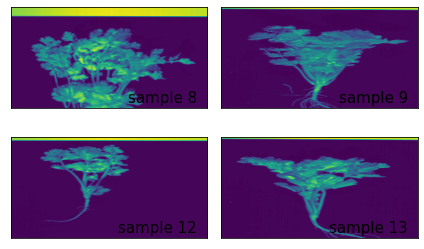

In [12]:
print('plot example of shorten sample data')
print('\n')

# show images of shorten data
figurename = 'Example of images in different samples from a single spectrum of shorten coriander sample data'

# find minimum raw data length
length_max_index = np.argmax([X_raw[index].shape[0] for index, _ in enumerate(X_raw)])

# find minimum raw data length
length_min_index = np.argmin([X_raw[index].shape[0] for index, _ in enumerate(X_raw)])

# set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

fig, axes = plt.subplots(nrows=2, ncols=2)

## sample 0th - 3th are selected
## Z; spectral, is randomly specified
axes[0, 0].imshow(X[length_max_index][:,:,50])
axes[0, 1].imshow(X[length_max_index + 1][:,:,50])
axes[1, 0].imshow(X[length_min_index - 1][:,:,50])
axes[1, 1].imshow(X[length_min_index][:,:,50])

# decorate
axes[0, 0].set_title(('sample ' + str(length_max_index)), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[0, 1].set_title(('sample ' + str(length_max_index + 1)), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[1, 0].set_title(('sample ' + str(length_min_index - 1)), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[1, 1].set_title(('sample ' + str(length_min_index)), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
# fig.suptitle(figurename, fontsize=MEDIUM_SIZE) # will be removed
fig.tight_layout()

# save figure
plt.savefig(defaultdir + '/processed_data/' + figurename + '.png')

# declare indices
print('sample index =', [length_max_index, length_max_index + 1, length_min_index - 1, length_min_index])
print('spectral index =', 50)
print('\n')

In [13]:
# define scaler function to adjust value using Z-score scaling
def data_scaler(X=X):

  # setup empty variable w/ the same shape to original tensor
  X_scaled = np.zeros_like(X)

  # scale along spectral domain
  for wavelength in range(X.shape[-1]):
      
      # define scaler method
      scaler = StandardScaler(with_mean=False) # specify to not centering data when dealing w/ sparse matrix
      
      # perform standardization -> assign to a temporary variable by
          # flatten all data points shape
          # standardize
          # reshape back to orignial shape
      X_scaled[:,:,:,wavelength] = scaler.fit_transform(X[:,:,:,wavelength].ravel().reshape(-1,1)).reshape(X[:,:,:,1].shape)
  
  return X_scaled

In [14]:
print('performing data standardization')

# perform scaler function
# !note: this process take some minutes
X = data_scaler(X=X)

print('data standardization has done')
print('\n')

performing data standardization
data standardization has done




plot example of images in different samples from a single spectrum of scaled coriander sample data
sample index = 2
spectral index = [0, 50, 100, 223]




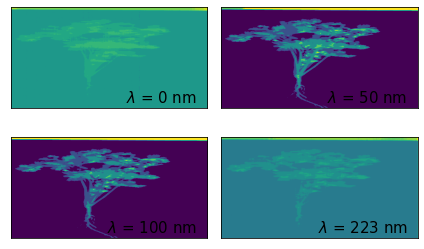

In [15]:
print('plot example of images in different samples from a single spectrum of scaled coriander sample data')

# show images of shorten data
figurename = 'Example of images in different samples from a single spectrum of scaled coriander sample data'
sample_index = 2

# set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

fig, axes = plt.subplots(nrows=2, ncols=2)

## sample 0th - 3th are selected
## Z; spectral, is randomly specified
axes[0, 0].imshow(X[sample_index][:,:,0])
axes[0, 1].imshow(X[sample_index][:,:,50])
axes[1, 0].imshow(X[sample_index][:,:,100])
axes[1, 1].imshow(X[sample_index][:,:,223])

axes[0, 0].set_title((r'$\lambda$ = 0 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[0, 1].set_title((r'$\lambda$ = 50 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[1, 0].set_title((r'$\lambda$ = 100 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
axes[1, 1].set_title((r'$\lambda$ = 223 nm'), fontsize=MEDIUM_SIZE, loc='right', x=0.95, y=0.1, pad=-5)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
# fig.suptitle(figurename, fontsize=MEDIUM_SIZE) # will be removed
fig.tight_layout()

# save figure
plt.savefig(defaultdir + '/processed_data/' + figurename + '.png')

# declare sample index
print('sample index =', sample_index)
print('spectral index =', [0, 50, 100, 223])
print('\n')

In [16]:
# delete unused data
del X_raw

In [ ]:
print('performing data splitting into train set & test set')
print('\n')

# Split data into training & testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

## duplicate datasets and reformat for non-Artificial Neural Network models
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X.reshape(X.shape[0], -1), np.argmax(y, axis=1), test_size=0.25, random_state=random_seed)

# delete unused data
del X
del y

# see splitted data
print('train input: ', len(X_train), '\t train label: ', len(y_train))
print('test input: ', len(X_test), '\t\t test label: ', len(y_test))
print('duplicate data for non-Artificial Neural Network models successes')
print('\n')

performing data splitting into train set & test set




In [ ]:
X_train

In [ ]:
X_train_sk

In [ ]:
y_train

In [ ]:
y_train_sk

In [ ]:
print('saving processed data')

# save processed datas into drive
np.save(defaultdir + '/processed_data/X_train', X_train)
np.save(defaultdir + '/processed_data/X_test', X_test)
np.save(defaultdir + '/processed_data/y_train', y_train)
np.save(defaultdir + '/processed_data/y_test', y_test)

print('saving done')
print('\n')

In [ ]:
print('Data Acquisition & Data Preprocessing complete')

# Data Acquisition & Data Preprocessing finish!